# Fermions on the square lattice & perfect nesting

This tutorial is the first in a series of tutorials on two-particle response were we will use TRIQS and the [**Two-Particle Response-Function toolbox (TPRF)**](https://triqs.github.io/tprf/latest/) to compute;

1. the **non-interacting Green's function** of fermions on the square lattice with nearest-neighbour hopping 
   and study the Fermi surface [01]

2. the **non-interacting two-particle response**, also called the susceptibility [03]

3. the **Random-Phase Approximation (RPA)** susceptibility for weak interactions, 
   studying the anti-ferromagnetic divergence at ($\pi,\pi)$ [05]

4. the **Two-Particle Self Conistent (TPSC)** susceptibility
   and show that it satisfies the Pauli principle, while RPA does not [07]
   
5. and show that TPSC obeys the **Mermin-Wagner theorem**,
   since its spin susceptibility does not diverge at finite temperature [09]


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from triqs.plot.mpl_interface import plt

import numpy as np

## Square lattice with nearest-neighbour hopping

The square lattice with nearest-neighbour hopping $t$ appeared in earier tutorials, were the dispersion relation 

\begin{equation}
  \epsilon(\mathbf{k})=-2t(\cos{k_x}+\cos{k_y}),
\end{equation}

was computed using TRIQS in more than one way.

However, in TRIQS and TPRF there are a number of helper routines for lattice models that simplifies the study of general tight-binding models. Here we will therefore use these standard routines.

Insead of constructing $\epsilon(\mathbf{k})$ directly in momentum space we construct a real-space tight binding lattice Hamitonian $H(\mathbf{r})$ using [the `TBLattice` class](https://triqs.github.io/triqs/latest/documentation/python_api/triqs.lattice.tight_binding.TBLattice.html?highlight=tblattice#triqs.lattice.tight_binding.TBLattice) corresponding to the square lattice with nearest neighbour hopping $t=1$.

In [2]:
from triqs.lattice.tight_binding import TBLattice

t = 1.0 # nearest-neigbhour hopping amplitude

H_r = TBLattice( 
    units=[
        (1,0,0), # basis vector in the x-direction 
        (0,1,0), # basis vector in the y-direction
    ],
    hoppings={
        (+1,0) : [[-t]], # hopping in the +x direction
        (-1,0) : [[-t]], # hopping in the -x direction
        (0,+1) : [[-t]], # hopping in the +y direction
        (0,-1) : [[-t]], # hopping in the -y direction
    })

print(H_r)

Tight Binding Hamiltonian on Bravais Lattice with dimension 2, units 
[[1,0,0]
 [0,1,0]
 [0,0,1]], n_orbitals 1
with hoppings [
   [1,0] : 
[[(-1,0)]]
   [-1,0] : 
[[(-1,0)]]
   [0,1] : 
[[(-1,0)]]
   [0,-1] : 
[[(-1,0)]] ]


Starting serial run at: 2023-08-28 21:50:34.510934


The real-space Hamiltonian $H(\mathbf{r})$ can both construct a discretized momentum mesh and evaluate the dispersion $\epsilon(\mathbf{k})$ on a given momentum mesh, by

In [3]:
n_k = 128
kmesh = H_r.get_kmesh(n_k=n_k)
e_k = H_r.fourier(kmesh)
print(e_k)

Greens Function  with mesh Brillouin Zone Mesh with linear dimensions (128 128 1)
 -- units = 
[[0.0490874,0,0]
 [0,0.0490874,0]
 [0,0,6.28319]]
 -- brillouin_zone: Brillouin Zone with 2 dimensions and reciprocal matrix 
[[6.28319,0,0]
 [0,6.28319,0]
 [0,0,6.28319]] and target_shape (1, 1): 



Since the square lattice is two-dimensional it is possible to visualize the dispersion using a color plot.

Here is an example that plots $\epsilon(\mathbf{k})$ in the entire Brillouin zone as well as the shape of the Fermi surface at $\omega = 0$ (dotted line).

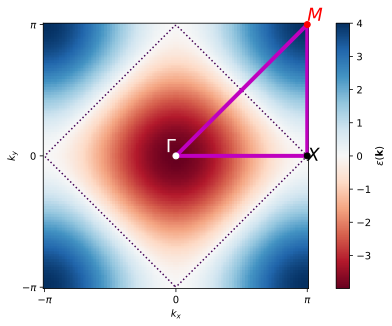

In [4]:
k = np.linspace(-np.pi, np.pi, num=100)
kx, ky = np.meshgrid(k, k)

e_k_interp = np.vectorize(lambda kx, ky : e_k((kx, ky, 0)).real)(kx, ky)

plt.figure()

plt.pcolormesh(kx, ky, e_k_interp, rasterized=True, cmap='RdBu')
plt.colorbar().ax.set_ylabel(r'$\epsilon(\mathbf{k})$'); 

plt.contour(kx, ky, e_k_interp, levels=[0], linestyles='dotted')

plt.xlabel(r'$k_x$'); plt.ylabel(r'$k_y$');
k_ticks, k_labels = [-np.pi, 0, np.pi], [r"$-\pi$", r"0", r"$\pi$"]
plt.xticks(k_ticks, k_labels); plt.yticks(k_ticks, k_labels);
plt.axis('square');

# -- High-symmetry path G-X-M-G

pts = [
    (0., 0., r'$\Gamma$', 'w', 'bottom', 'right'), 
    (np.pi, 0., r'$X$', 'k', 'center', 'left'),
    (np.pi, np.pi, r'$M$', 'r', 'bottom', 'left'),
    ]
for x, y, label, color, va, ha in pts:
    plt.plot(x, y, 'o', color=color, clip_on=False, zorder=110)
    plt.text(x, y, label, color=color, fontsize=18, va=va, ha=ha)

X, Y, _, _, _, _ = zip(*(pts+[pts[0]]))
plt.plot(X, Y, '-m', zorder=100, lw=4);

Momentum dependent quantities can also be visualized along high-symmetry paths in the Brillouin zone, see above for the high-symmetry points $\Gamma$, $X$ and $M$ of the square lattice. 

Here is an example that plots the dispersion $\epsilon(\mathbf{k})$ along thepath $\Gamma - X - M - \Gamma$ in k-space using [the `triqs_tprf.lattice_utils.k_space_path` function](https://triqs.github.io/tprf/unstable/reference/python_reference.html#triqs_tprf.lattice_utils.k_space_path).

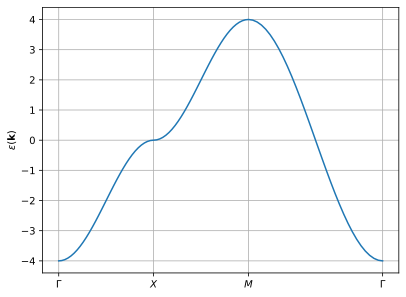

In [5]:
G = [0.0, 0.0, 0.0]
X = [0.5, 0.0, 0.0]
M = [0.5, 0.5, 0.0]

path = [(G, X), (X, M), (M, G)]

from triqs_tprf.lattice_utils import k_space_path

k_vecs, k_plot, k_ticks = k_space_path(path, num=32, bz=H_r.bz)

e_k_interp = np.vectorize(lambda k : e_k(k).real, signature='(n)->()')

plt.plot(k_plot, e_k_interp(k_vecs))
plt.xticks(k_ticks, labels=[r'$\Gamma$', '$X$', '$M$', r'$\Gamma$'])
plt.ylabel(r'$\epsilon(\mathbf{k})$')
plt.grid(True)

In the following we will re-purpose these visualization scripts to study the one-particle and two-particle Green's functions of the square lattice model.

## Non-interacting lattice Green's function

Given the dispersion $\epsilon(\mathbf{k})$ the non-interacting Green's function $G_0(i\omega_n, \mathbf{k})$ is given by

\begin{equation}
  G_0(i\omega_n, \mathbf{k}) = \frac{1}{i\omega_n - \epsilon(\mathbf{k})}
  \, .
\end{equation}

As shown in the Basic Tutorial it is of course possible to compute $G_0$ using a loop over frequency and momentum:

```python
from triqs.gf import Gf, MeshImFreq, MeshProduct

wmesh = MeshImFreq(beta=2.5, S='Fermion', n_max=128)
wkmesh = MeshProduct(wmesh, kmesh)
g0_wk = Gf(mesh=wkmesh, target_shape=e_k.target_shape)

for w, k in wkmesh:    
    g0_wk[w, k] = 1/(w - e_k[k])
```

However, TPRF has Dyson equation solvers that are OpenMP+MPI parallell and all implemented in C++, see [the TPRF documentation](https://triqs.github.io/tprf/latest/reference/python_reference.html#lattice-green-s-functions). Here we will use these fast routines!

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1:

Use [`triqs_tprf.lattice.lattice_dyson_g0_wk`](https://triqs.github.io/tprf/latest/reference/python_reference.html#triqs_tprf.lattice.lattice_dyson_g0_wk) to compute $G_0(i\omega_n, \mathbf{k})$ at inverse temperature $\beta = 2.5$ using a [fermionic `MeshImFreq` frequency mesh](https://triqs.github.io/triqs/latest/documentation/python_api/triqs.gf.meshes.MeshImFreq.html?highlight=meshimfreq#triqs.gf.meshes.MeshImFreq)  with 128 Matsubara frequencies and name the resulting Green's function `g0_wk`.

Check the properties of `g0_wk` by printing it, i.e.
```python
print(g0_wk)
```

In [ ]:
# Write your code here


**Questions**

- How many meshes does the Green's function have?
- What is the k-space discretization?
- How is the reciprocal basis vectors of the Brillouin zone related to the lattice (`units`) vectors of the tight binding lattice `H_r` above?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2:

Save the Green's function `g0_wk` into a hdf5 file named `g0_wk.h5` using [`h5.HDFArchive`](https://triqs.github.io/triqs/latest/documentation/manual/triqs/hdf5/ref.html), so that we can read `g0_wk` from file in the following tutorials. Do the same with the dispersion `e_k` and save it to a file with the name `e_k.h5`.

In [ ]:
# Write your code here


## Fermi surface nesting

We will now study the Fermi surface of Fermions on the square lattice with nearest neighbour hopping, which has a special property called *perfect nesting*. A Fermi surface is said to be *nested* if parts of the Fermi surface map to each other by a single momentum vector $\mathbf{Q}$, called the *nesting vector*.

For a non-interacting system the Fermi surface is the surface in k-space defined by

$$ \epsilon(\mathbf{k}) - \mu = 0 \, ,$$

where $\mu$ is the chemical potential. In terms of the spectral function $A(\omega, \mathbf{k})$ this corresponds to large values of $A$ at $\omega=0$

$$ A(\omega = 0, \mathbf{k}) = \frac{1}{\pi} \text{Im} 
\left[ \frac{1}{ 0 - \epsilon(\mathbf{k}) + \mu - i\delta } \right] \gg 1 \, ,$$

which also generalizes to interacting systems.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3:

Make a color plot of the zero-frequency spectral function $A(k, \omega=0)$ over the Brillouin zone, using the approximation

$$ A(k, \omega=0) \approx -\frac{1}{\pi} \text{Im}[ G_0(\mathbf{k}, i\omega_0) ] \, ,$$

where we neglect the fact that the first fermionic Matsubara frequency $i\omega_0$ is not exactly $0$.

The right hand side can be evaluated using the Triqs Green's function `g0_wk` and the interpolation feature:

```python
n = 0 # Matsubara frequency index
kx, ky, kz = 0., 0., 0.
k_vec = (kx, ky, kz)
g0_wk(n, k_vec)
```

In [ ]:
# Write your code here


**Hint**: Re-purpose the code for the color plot of $\epsilon(\mathbf{k})$ above.

**Questions**

  * How can we see from the plot that the Fermi surface is nested?
  * What is the nesting vector?
  * Actually the Fermi surface is **perfectly** nested. What do you think is the difference between *nesting* and *perfect nesting*?

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 4:

For non-interacting systems the Fermi surface can also be observed in the Fermionic density distribution in k-space $\rho(\mathbf{k})$, which can be computed from the Matsubara Green's function $G_0(i\omega_n, \mathbf{k})$.

In TRIQS this is available through the `.density()` method of Matsubara frequency Green's functions. For the lattice Green's function it can be evaluated for a given k-vector using

```python
kx, ky, kz = 0., 0., 0.
k_vec = (kx, ky, kz)
rho_k = g0_wk(all, k_vec).density().real
```

Plot the momentum distribution $\rho(\mathbf{k})$ along the Brillouin zone high-symmetry path $\Gamma - X - M - \Gamma$.

In [ ]:
# Write your code here


**Hint**: Re-purpose the code above plotting $\epsilon(\mathbf{k})$ along the same path.

**Questions**

- What is the value of $\rho(\mathbf{k})$ at the Fermi surface?
- What is the sign of $\epsilon(\mathbf{k})$ in the regions of k-space where $\rho(\mathbf{k}) \approx 1$ and $\approx 0$, respectively?
- How is this related to the Fermi distribution function $$f(\epsilon) = \frac{1}{1 + e^{\beta \epsilon}}$$ plotted below?

In [ ]:
beta = 2.5
e = np.linspace(-4., 4.)
f = lambda e : 1/(1 + np.exp(beta * e))
plt.plot(e, f(e))
plt.xlabel(r'$\epsilon$'); plt.ylabel(r'$f(\epsilon)$'); plt.grid(True);